In [1]:
from __future__ import print_function

In [2]:
!pip install vit-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 556.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00


In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.7 MB/s eta 0:00:00


In [4]:
!pip install tqdm

In [5]:
import glob
import os
import random
from google.colab import drive
import glob
import os
import random
import time
from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import timm
model = timm.create_model('vit_base_patch16_224', pretrained=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [6]:
drive.mount('/content/drive')

def get_files_from_folder(folder_path):
    file_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpeg'):
                file_list.append(os.path.join(root, file))
    return file_list

Mounted at /content/drive


In [7]:
# "chest_xray" klasörünün yolunu belirleyin
folder_path = '/content/drive/MyDrive/chest_xray'

# Klasör ve alt klasörlerinden dosyaları alın
train_list = get_files_from_folder(folder_path)

print(f"Train list length: {len(train_list)}")

Train list length: 5856


In [8]:
random.shuffle(train_list)

train_list, test_list = train_test_split(train_list,
                                          test_size=0.15,
                                          random_state=42)

test_list, valid_list = train_test_split(test_list,
                                          test_size=0.33,
                                          random_state=42)


In [9]:
print(f"Train Data: {len(train_list)}")
print(f"Valid Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 4977
Valid Data: 291
Test Data: 588


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 32
epochs = 10
lr = 0.001
gamma = 0.1


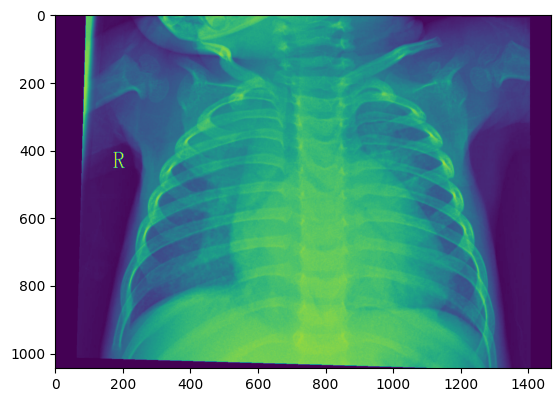

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(train_list[0])
imgplot = plt.imshow(img)
plt.show()

In [12]:
import imageio
im = imageio.imread(train_list[0])
im.shape


<ipython-input-12-a77c4ee6fd7e>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(train_list[0])


(1044, 1467)

In [13]:
from PIL import Image
img = Image.open(train_list[0]).convert('RGB')
img = img.save("geeks.jpg")


In [14]:
im = imageio.imread("geeks.jpg")

<ipython-input-14-893296838ed3>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread("geeks.jpg")


In [15]:
im.shape

(1044, 1467, 3)

In [16]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.ToTensor(),
    ]
)

valid_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [17]:
class BreakHisDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-4].split(".")[0]
        label = 1 if label == "malignant" else 0

        return img_transformed, label

In [18]:
train_data = BreakHisDataset(train_list, transform=train_transforms)
valid_data = BreakHisDataset(valid_list, transform=valid_transforms)
test_data = BreakHisDataset(test_list, transform=test_transforms)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [ ]:
import torch.nn as nn
num_classes = 2
model.head = nn.Linear(model.head.in_features, num_classes)
model.to(device)

In [21]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

best_loss = float('inf')
patience = 15
trigger = 0

start_time = time.time()

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    model.train()
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss.item() / len(train_loader)

  0%|          | 0/156 [00:00<?, ?it/s]

In [ ]:

    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label invalid_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += loss.item() / len(valid_loader)


In [ ]:
    train_loss_list.append(epoch_loss)
    train_accuracy_list.append(epoch_accuracy)
    val_loss_list.append(epoch_val_loss)
    val_accuracy_list.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")
    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

In [ ]:

    if epoch_val_loss < best_loss:
        trigger = 0
        best_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping!")
            break


In [ ]:
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")